### `Gather` Tutorial

This tutorial introduces a reader to a `Gather` class: a simple object that stores seismic traces and provides an interface for their processing. <br>
The notebook demonstrates how to create `Gather` instances and shows their most useful attributes and processing methods.

### Content

[Introduction](#Introduction) <br>
[Creating a gather](#Creating-a-gather) <br>
[Attributes](#Attributes) <br>
[General Methods](#General-Methods)<br>
[Normalization Methods](#Normalization-Methods) <br>
[Signal Processing Methods](Signal-Processing-Methods) <br>
[Muting Methods](#Muting-Methods) <br>
[Conclusion](#Conclusion) <br>

In [1]:
import sys

import matplotlib.pyplot as plt

from utils import generate_trace

sys.path.append('..')
from seismicpro import Survey, Muter, make_prestack_segy

### Introduction

`Survey` class is a concise representation of a SEG-Y file: while it contains specified trace headers, it does not store any seismic data to keep memory footprint to a minimum. Instead, it provides a way to process seismic data gather-wise, which is very convenient when working with Machine Learning tasks. <br>
To work with trace data, one needs to use `Gather` class: it contains a subset of `Survey`'s headers selected by common `header_index` value and the corresponding seismic traces.

The scheme below demonstrates which information from SEG-Y files is stored in instances of `Survey` and `Gather` classes. <br>
Here an instance of `Survey` is created with `'FieldRecord'` as `header_index` and `['TraceNumber', 'offset', 'CDP']` as `header_cols`: <br>
```python
survey = Survey(sgy_path, header_index='FieldRecord', header_cols=['TraceNumber', 'offset', 'CDP'])
```
A `Gather` instance created with the following line
```python
gather = survey.get_gather(912)
```
will contain a subset of its parent survey headers that share the common value of `FieldRecord` equal to 912 and the corresponding seismic traces from the SEG-Y file.

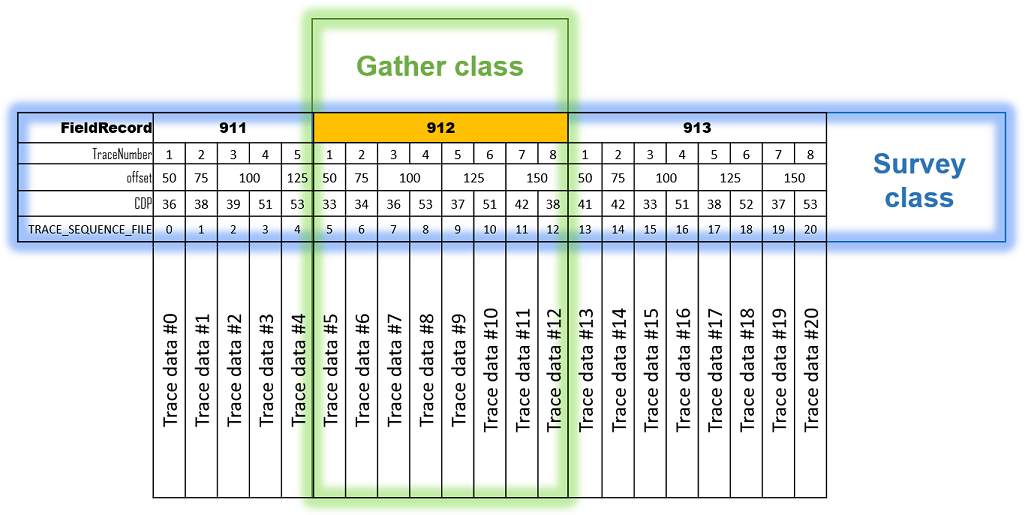

### Creating a gather

For convenience, this tutorial uses a SEG-Y file with synthetic data that is going to be generated in the following cell:

In [2]:
sgy_path = '/data/synthetic_survey.sgy'
make_prestack_segy(sgy_path, survey_size=(1500, 1500), activation_dist=(1500, 1500), trace_gen=generate_trace)

Common shot gathers generated:   0%|          | 0/150 [00:00<?, ?it/s]

To learn more about the `Survey` class, see [Survey tutorial](./1_Survey.ipynb).

In [3]:
survey = Survey(sgy_path, header_index='FieldRecord', header_cols=['TraceNumber', 'offset'])
survey.mark_dead_traces()
survey.collect_stats()

Trace headers loaded:   0%|          | 0/135000 [00:00<?, ?it/s]

Detecting dead traces for survey synthetic_survey:   0%|          | 0/135000 [00:00<?, ?it/s]

Calculating statistics for traces in survey synthetic_survey:   0%|          | 0/135000 [00:00<?, ?it/s]

`Survey` provides two methods to generate `Gather` instances: `Survey.get_gather()` and `Survey.sample_gather()`.

<b> `get_gather()`</b>

To create a `Gather` instance using `get_gather()` one needs to provide an index from `survey.indices`, which will be used to load corresponding traces from SEG-Y file and make a subset of `survey.headers` `DataFrame`. <br>

In [4]:
survey.headers

TRACE_SEQUENCE_FILE  TraceNumber  offset  TRACE_POS_IN_SURVEY  \
FieldRecord                                                                  
0                              1            0       0                    0   
0                              2            1      25                    1   
0                              3            2      50                    2   
0                              4            3      75                    3   
0                              5            4     100                    4   
...                          ...          ...     ...                  ...   
149                       134996          895     182               134995   
149                       134997          896     206               134996   
149                       134998          897     230               134997   
149                       134999          898     254               134998   
149                       135000          899     279               134999   

             DeadTrace  
FieldRecord             
0                False  
0                False  
0                False  
0                False  
0                False  
...                ...  
149              False  
149              False  
149              False  
149              False  
149              False  

[135000 rows x 5 columns]

Different values from <b>FieldRecord</b> column will result in different common shot gathers. Let's load a gather with <b>FieldRecord</b> equal to 0:

In [5]:
gather = survey.get_gather(index=0)

Now take a look at the information about the resulting `gather` using its `info()` method:

In [6]:
gather.info()

Parent survey path:          /data/synthetic_survey.sgy
Parent survey name:          synthetic_survey

Number of traces:            900
Trace length:                1500 samples
Sample interval:             2.0 ms
Sample rate:                 500.0 Hz
Times range:                 [0.0 ms, 2998.0 ms]
Offsets range:               [0 m, 2033 m]

Indexed by:                  FieldRecord
Index value:                 0
Gather coordinates:          Unknown
Gather sorting:              None

Gather statistics:
Number of dead traces:       0
mean | std:                        0.01 | 0.62      
 min | max:                       -8.59 | 5.62      
 q01 | q99:                       -1.58 | 1.90


<b> Note: </b>
In case a gather is created from a survey with defined limits, traces will be loaded within the specified limits.

<b>`sample_gather()`</b>

`sample_gather()` method does the same as `get_gather()`, but selects a gather index randomly:
```python
gather = survey.sample_gather()
```

### Attributes

Let's look at some useful attributes of the `Gather` class:

<b>`headers`</b> - `pandas.Dataframe` containing a subset of the parent `Survey`'s headers corresponding to the gather index.

In [7]:
gather.headers

TRACE_SEQUENCE_FILE  TraceNumber  offset  TRACE_POS_IN_SURVEY  \
FieldRecord                                                                  
0                              1            0       0                    0   
0                              2            1      25                    1   
0                              3            2      50                    2   
0                              4            3      75                    3   
0                              5            4     100                    4   
...                          ...          ...     ...                  ...   
0                            896          895    1962                  895   
0                            897          896    1979                  896   
0                            898          897    1997                  897   
0                            899          898    2015                  898   
0                            900          899    2033                  899   

             DeadTrace  
FieldRecord             
0                False  
0                False  
0                False  
0                False  
0                False  
...                ...  
0                False  
0                False  
0                False  
0                False  
0                False  

[900 rows x 5 columns]

<b>`indexed_by`</b> - names of trace headers defining the gather type. <br>

In [8]:
gather.indexed_by

'FieldRecord'

<b>`index`</b> - a value of trace headers the gather is indexed by.

In [9]:
gather.index

0

<b>`n_traces`</b> - the number of traces in the gather, a shortcut for `len(gather.headers)`. <br>

In [10]:
gather.n_traces

900

<b>`sample_interval` </b> - sampling interval of gather traces in milliseconds.

In [11]:
gather.sample_interval

2.0

<b>`sample_rate` </b> - sampling rate of gather traces in Hz.

In [12]:
gather.sample_rate

500.0

<b>`samples`</b> or <b>`times`</b> - arrays of recording times of trace samples in milliseconds. Difference between each two adjacent values equals to the `sample_interval`.

In [13]:
gather.samples

array([0.000e+00, 2.000e+00, 4.000e+00, ..., 2.994e+03, 2.996e+03,
       2.998e+03])

<b>`n_samples`</b> or <b>`n_times`</b> - the number of samples in each trace, a shortcut for `len(gather.samples)`. <br>

In [14]:
gather.n_samples

1500

<b>`data`</b> - two-dimensional `numpy.ndarray` containing amplitudes of gather traces. Has (`n_traces`, `n_samples`) shape. Positions of traces in `data` and `headers` correspond each other: headers of `i`-th trace from `data` are stored in the `i`-th row of `headers`.

In [15]:
gather.data

array([[-1.1590648 , -1.4182422 , -1.6246868 , ...,  0.8787574 ,
         0.553603  ,  0.19017826],
       [-1.031191  , -1.3956486 , -1.7786947 , ...,  1.279309  ,
         1.0096586 ,  0.6715166 ],
       [-0.03592439, -0.06599771, -0.11561459, ...,  1.4720179 ,
         1.4062203 ,  1.1902041 ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.65049136,
         0.2575122 , -0.17187694],
       [ 0.        ,  0.        ,  0.        , ...,  1.3686742 ,
         1.154052  ,  0.83595234],
       [ 0.        ,  0.        ,  0.        , ...,  1.5221821 ,
         1.3451238 ,  1.0529797 ]], dtype=float32)

<b>`shape`</b> - shape of the `data` array, a shortcut for `gather.data.shape`.

In [16]:
gather.shape

(900, 1500)

### General Methods

Note that most of the methods described below work inplace.

<b>`plot()`</b>

`plot()` method displays gather's seismic data. It supports a number of visualisation modes and many formatting parameters, which will be described in detail in a separate tutorial.

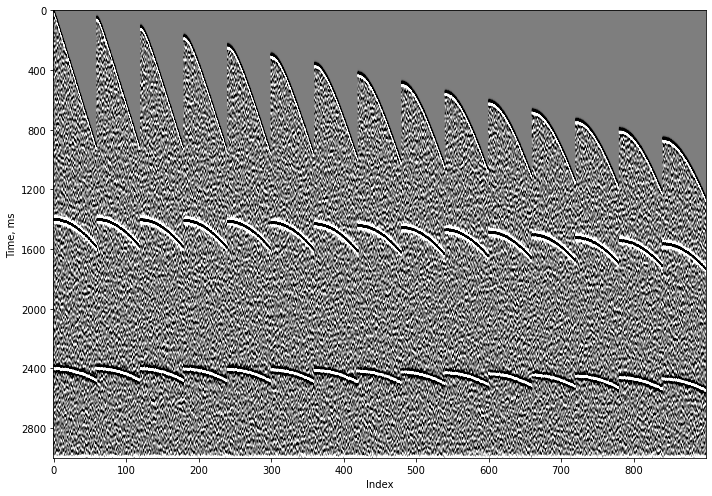

In [17]:
gather.plot()

`plot()` uses `'gray'` colormap by default, where white and black colors represent high and low values respectively. <br>
The Y-axis of the plot corresponds to time by default and the X-axis corresponds to the current gather sorting. If current sorting is unknown, X-axis just enumerates the traces as in the above image. <br>

<b>`sort()` </b>

Sort gather traces by values of a given trace header. Sorts only in ascending order.

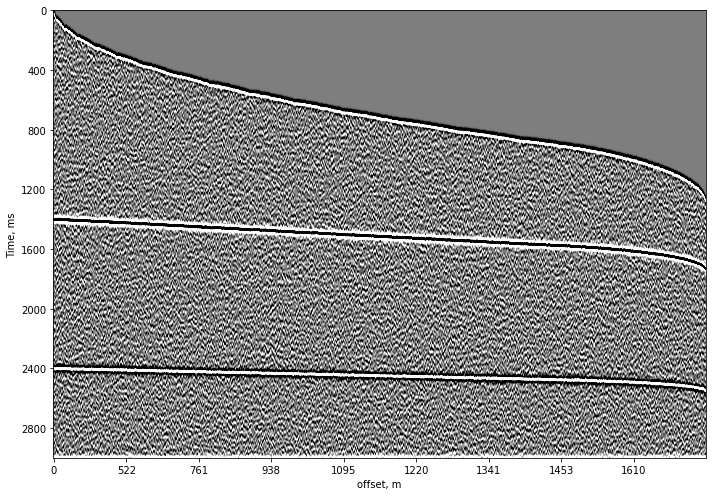

In [18]:
gather.sort(by='offset')
gather.plot()

`sort_by` attribute of the gather shows the current sorting:

In [19]:
gather.sort_by

'offset'

<b>`copy()`</b>

Make a copy of a `Gather` instance. <br>
As was mentioned before, most of the `Gather`'s methods change its data inplace. Using `copy()` allows working with a copy of a gather while keeping the original one unchanged.

While the sorting of `gather_copy` has changed, original `gather` still has `offset` sorting:

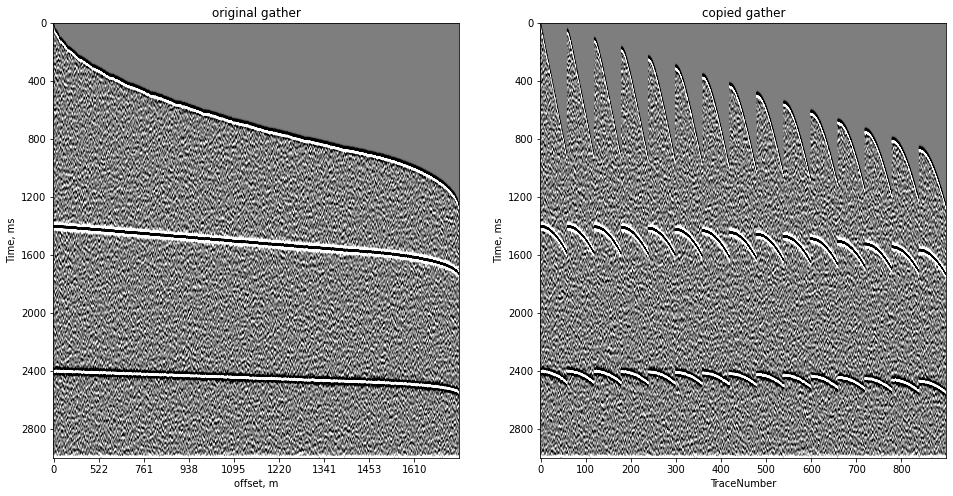

In [20]:
gather_copy = gather.copy()
gather_copy.sort(by='TraceNumber')

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
gather.plot(ax=ax1, title='original gather')
gather_copy.plot(ax=ax2, title='copied gather')

<b>`dump()` </b>

Write trace data and headers from a gather into a SEG-Y file. <br>

In [21]:
gather.dump(path='./data/', name='test')

Here `path` is a directory to save the SEG-Y file to; `name` is an optional parameter that defines a name of the SEG-Y file. If `name` is not provided, it will be inferred from survey name and gather index.

### Normalization Methods

Normalization methods transform `Gather`'s data by shifting and scaling. These transformations are useful to prepare the data for ML model training.

Behavior of all normalization methods depend on the combination of `tracewise` and `use_global` flags:
1. `tracewise=True, use_global=False`, default <br>
In this case normalization parameters are calculated for each trace independently.

2. `tracewise=False, use_global=False`<br>
Normalization parameters are calculated using data of all traces in the gather.

3. `use_global=True`<br>
In this case `tracewise` flag is ignored and normalization methods use statistics calculated by the parent `Survey` instance.

<b>`scale_standard()` </b>

Normalize gather data by shifting the data to zero mean scaling to unit variance.

In [22]:
gather_scaled = gather.copy()
gather_scaled.scale_standard()

print(f'Raw gather first trace mean: {gather.data[0].mean():.2f}, std: {gather.data[0].std():.2f}')
print(f'Scaled gather first trace mean: {gather_scaled.data[0].mean():.2f}, std: {gather_scaled.data[0].std():.2f}')

Raw gather first trace mean: 0.01, std: 0.63
Scaled gather first trace mean: 0.00, std: 1.00


If `use_global` parameter is set to `True`, normalization methods use statistics from parent `Survey` instance. It is important to note that one needs to collect survey statistics first by calling `Survey.collect_stats()` method.

In [23]:
gather_scaled = gather.copy()
gather_scaled.scale_standard(use_global=True)

print(f'Survey data mean: {survey.mean:.2f}, std: {survey.std:.2f}')
print(f'Scaled gather first trace mean: {gather_scaled.data[0].mean():.2f}, std: {gather_scaled.data[0].std():.2f}')

Survey data mean: 0.01, std: 0.63
Scaled gather first trace mean: 0.00, std: 1.00


Since survey's mean and standard deviation differ from the trace's statistics, it is essential that the scaled trace may not have zero mean and unit variance.

<b>`scale_maxabs()`</b>

Scale gather data by maximum absolute value. In this example, `tracewise` flag is set to `False`, so that scaling is performed over the whole gather.

In [24]:
gather_scaled = gather.copy()
gather_scaled.scale_maxabs(tracewise=False)

print(f'Absolute minimum of the scaled gather: {gather_scaled.data.min():.2f}')
print(f'Absolute maximum of the scaled gather: {gather_scaled.data.max():.2f}')

Absolute minimum of the scaled gather: -1.00
Absolute maximum of the scaled gather: 0.65


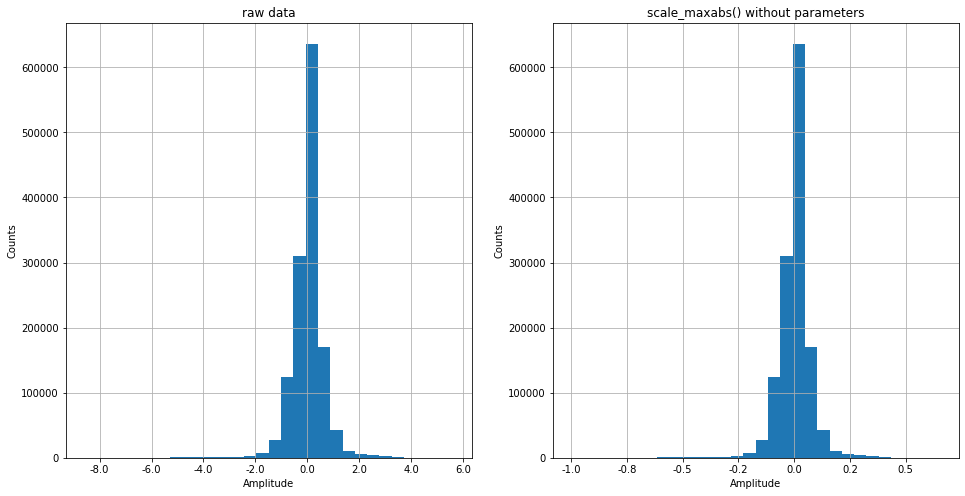

In [25]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
gather.plot('hist', bins=30, ax=ax1, title='raw data')
gather_scaled.plot('hist', bins=30, ax=ax2, title='scale_maxabs() without parameters',
                   x_ticker={'round_to': 1})  # x_ticker parameter is used to format x-axis ticker labels

Outliers in data strongly affect the results of `scale_maxabs()` normalization and most data points end up in a small region around zero. <br>
To deal with this problem, one can use `q_min` and `q_max` parameters; if specified, `q_min`th and `q_max`th quantiles will be used as minimum and maximum values in `scale_maxabs()` instead of absolute minimum and maximum. 

In [26]:
gather_scaled_quantile = gather.copy()
gather_scaled_quantile.scale_maxabs(q_min=0.01, q_max=0.99, tracewise=False)

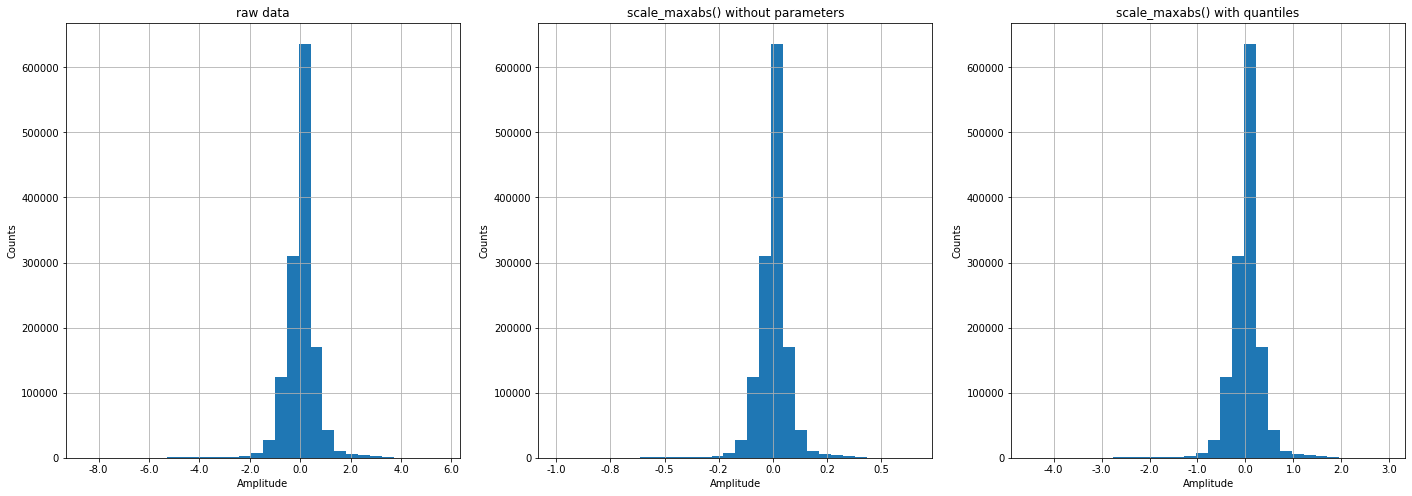

In [27]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
gather.plot('hist', bins=30, ax=ax1, title='raw data')
gather_scaled.plot('hist', bins=30, ax=ax2, title='scale_maxabs() without parameters', x_ticker={'round_to': 1})
gather_scaled_quantile.plot('hist', bins=30, ax=ax3, title='scale_maxabs() with quantiles')

Comparing X-axis limits you can see improvements in data distribution around zero, but the outliers still remain. To fix this, one can use `clip` flag, which clips values outside the [-1, 1] interval to the interval edges.<br>

In [28]:
gather_scaled_clip = gather.copy()
gather_scaled_clip.scale_maxabs(q_min=0.01, q_max=0.99, clip=True, tracewise=False)

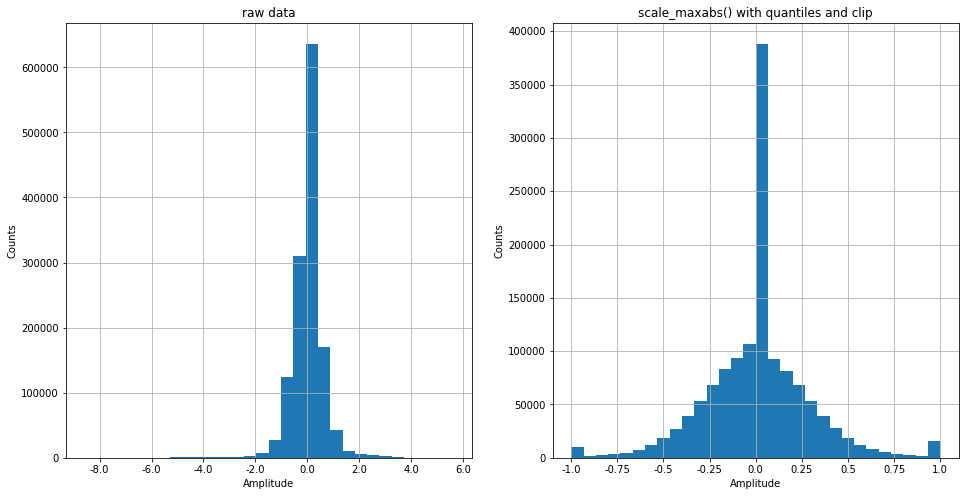

In [29]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
gather.plot('hist', bins=30, ax=ax1, title='raw data')
gather_scaled_clip.plot('hist', bins=30, ax=ax2, title='scale_maxabs() with quantiles and clip')

<b>`scale_minmax()` </b>

Shift and scale trace data to a [0, 1] interval.

In [30]:
gather_scaled = gather.copy()
gather_scaled.scale_minmax()

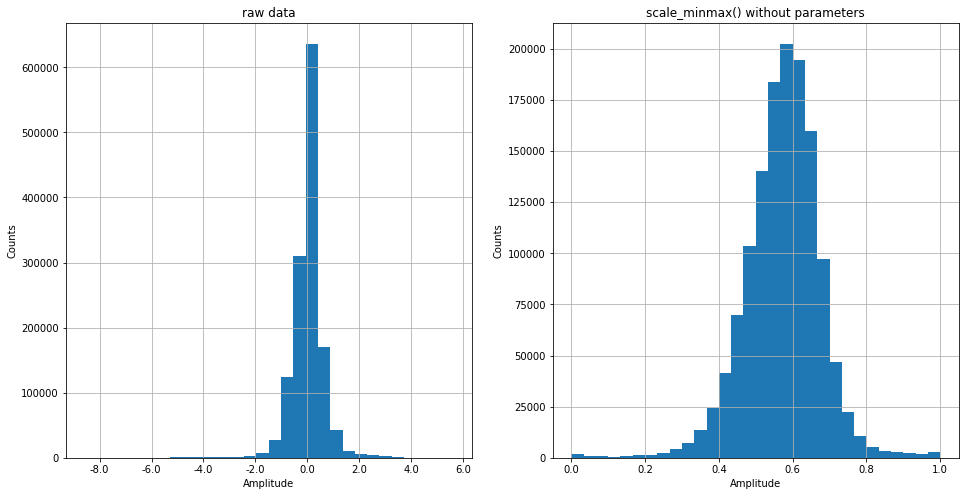

In [31]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
gather.plot('hist', bins=30, ax=ax1, title='raw data')
gather_scaled.plot('hist', bins=30, ax=ax2, title='scale_minmax() without parameters', x_ticker={'round_to': 1})

`scale_minmax()` also supports usage of quantiles and clipping, but now clipping is performed to a [0, 1] interval. 

In [32]:
gather_scaled_quantile = gather.copy()
gather_scaled_quantile.scale_minmax(q_min=0.02, q_max=0.98)

In [33]:
gather_scaled_clip = gather.copy()
gather_scaled_clip.scale_minmax(q_min=0.02, q_max=0.98, clip=True)

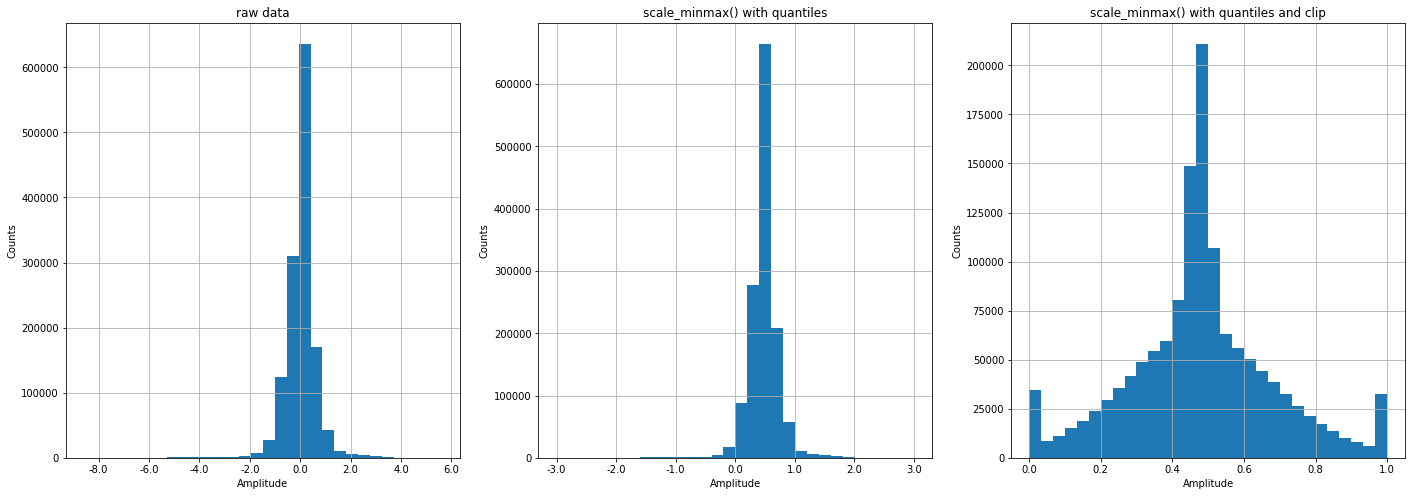

In [34]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))
gather.plot('hist', bins=30, ax=ax1, title='raw data')
gather_scaled_quantile.plot('hist', bins=30, ax=ax2, title='scale_minmax() with quantiles')
gather_scaled_clip.plot('hist', bins=30, ax=ax3, title='scale_minmax() with quantiles and clip', x_ticker={'round_to': 1})

### Signal Processing Methods

<b>`bandpass_filter()`</b>

`bandpass_filter()` is used to filter the frequency spectrum of a gather; if only one of parameters - low or high - is passed, it acts as a highpass or lowpass filter.

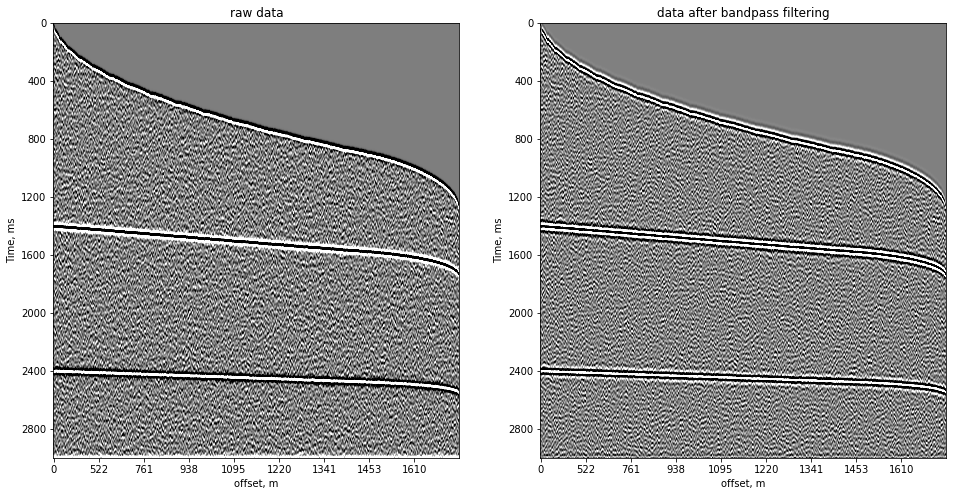

In [35]:
gather_bandpass = gather.copy()
gather_bandpass.bandpass_filter(low=20, high=80)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
gather.plot(ax=ax1, title='raw data')
gather_bandpass.plot(ax=ax2, title='data after bandpass filtering')

<b>`resample()`</b>

This method changes sample interval of traces in the gather.

In [36]:
gather_resample = gather.copy()
gather_resample.resample(new_sample_interval=4)

In [37]:
gather_resample.sample_interval

4.0

The number of samples in each trace changes accordingly:

In [38]:
print(f'The number of samples in the original gather: {gather.n_samples}')
print(f'The number of samples in the resampled gather: {gather_resample.n_samples}')

The number of samples in the original gather: 1500
The number of samples in the resampled gather: 750


<b>`apply_agc()`</b>

AGC - automatic gain control - is usually applied to seismic data to bring up weak signals and level them off with the high-amplitude signals.

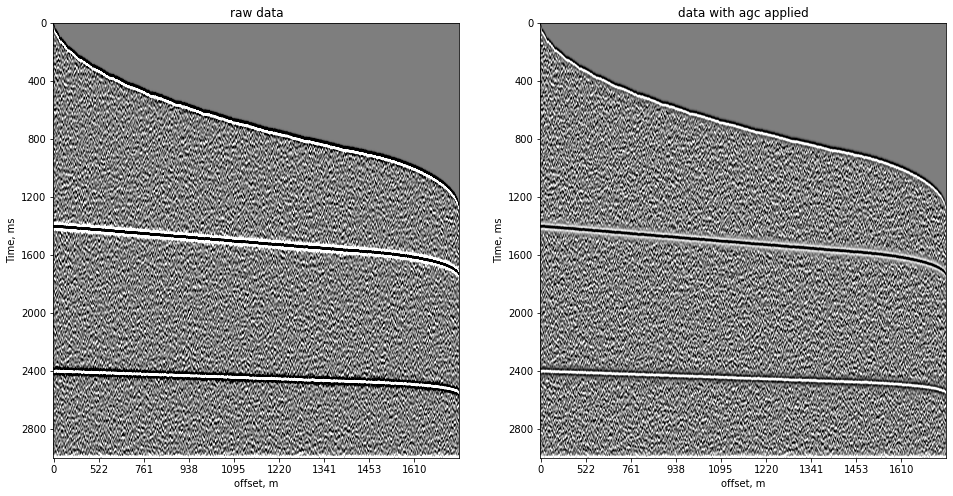

In [39]:
gather_agc = gather.copy()
gather_agc.apply_agc(window_size=64)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
gather.plot(ax=ax1, title='raw data')
gather_agc.plot(ax=ax2, title='data with agc applied')

<b>`apply_sdc()`</b>

`apply_sdc()` introduces spherical divergence correction that copensates for gradual decay of amplitudes at later times which occurs due to energy dissipation while the wave propagates through the ground.

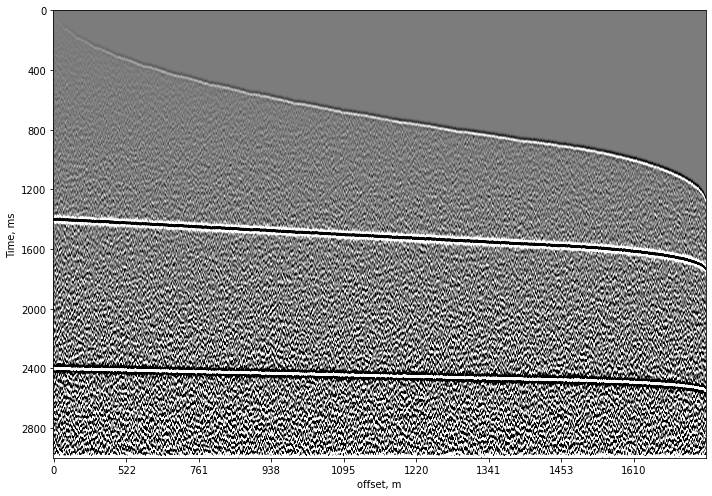

In [40]:
gather_sdc = gather.copy()
gather_sdc.apply_sdc()
gather_sdc.plot()

Since synthetic data in this tutorial already has SDC introduced, `apply_sdc` overamplifies amplitudes at later times.

<b>`undo_sdc()`</b>

At the later stages of the seismic processing pipeline it is required to revert  spherical divergence corrections. Applying `undo_sdc` to the `gather_sdc` will restore it back to normal:

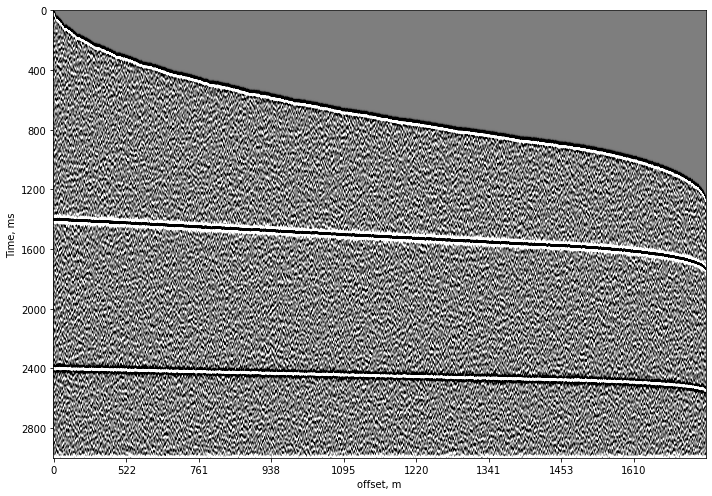

In [41]:
gather_sdc.undo_sdc()
gather_sdc.plot()

### Muting Methods

Muting is a process when a part of a seismic trace, most often its beginning, is zeroed. It is commonly used, for example, to remove high aplitudes in the area of first arrivals.

<b>`mute()`</b> method takes an instance of a `Muter` class as an input: it defines an offset-time boundary above which gather values will be set to zero. <br>
The easiest way to create a muter is to specify arrays of offsets and times defining knots of a piecewise linear muting boundary:

In [42]:
muter = Muter(offsets=[127, 1500, 3000, 4949], times=[400, 1200, 2200, 3300])

Now gather muting can be performed:

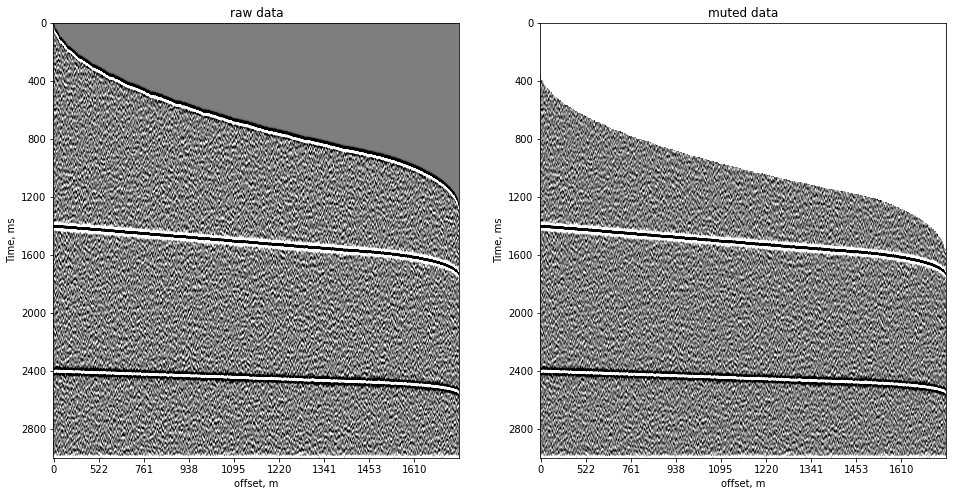

In [43]:
gather_muted = gather.copy()
gather_muted.mute(muter)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
gather.plot(ax=ax1, title='raw data')
gather_muted.plot(ax=ax2, title='muted data')

### Conclusion

This tutorial:
- explained the purpose of the `Gather` class and ways of its instantiation,
- listed main attributes of the `Gather` and their contents,
- showed `Gather`'s processing methods and how they affect the data.

[Go to top](#Gather-Tutorial)